In [4]:
from pathlib import Path
import os
from IPython.display import clear_output

import torch
import torchvision
from torchvision import transforms as T
from torch import nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import random
from tqdm.auto import tqdm

from ptflops import get_model_complexity_info

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(1)

# Бонус

Модели из статьи уже есть в `torchvision.models`

In [66]:
# предобученные модели
# regnet_x = torchvision.models.regnet_x_400mf(pretrained=True)
# regnet_y = torchvision.models.regnet_y_32gf(pretrained=True)

# всякие блоки-конструкторы
# see torchvision.models.regnet...

# Designing LCNN Design Space

В статье [On Network Design Spaces for Visual Recognition](https://arxiv.org/pdf/1905.13214.pdf) рассказывается как сравнивать разные пространства моделей.

В [Designing Network Design Spaces](https://arxiv.org/pdf/2003.13678.pdf) приводится **методология** построения пространств моделей и сведения их к более (а) простым (б) качественным

---

Попробуем повторить исследование в мини-формате. 

Вместо ImageNet будем использовать CIFAR. В качестве основной сети возьмем [LightCNN, LCNN](https://arxiv.org/pdf/1511.02683.pdf), которая часто используется в Face Recogntion и Voice Anti-spoofing. 

**Справка:** 

LCNN по сути это обычная CNN, в которой все активации это Max-Feature-Map (MFM) и некоторые слои являются Network In Network [(NIN)](https://arxiv.org/pdf/1312.4400.pdf) -- Conv2d заменяется на многомерный Linear.

![MFM](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/94f74c6314ffd02db581e8e887b5fd81ce288dbf/1-Figure1-1.png)

Если не хотите читать статью, то посмотрите в код ниже, там все понятно. MFM задается в Классе `mfm` в `forward`, а NIN это `mfm(type=0)`

---

### Скачаем данные и стандартно запрепроцессим + зададим функции для train\test

In [2]:
batch_size = 32

transforms = T.Compose([
    T.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
acc_mean = 0
acc_std = 0
for images, _ in trainloader:
    mean = images.mean(dim=(0, 2, 3))
    std = images.std(dim=(0, 2, 3))
    acc_mean += mean
    acc_std += std
    
print(f'Значения mean для Normalize: {acc_mean / len(trainloader)}')
print(f'Значения std для Normalize: {acc_std / len(trainloader)}')

Значения mean для Normalize: tensor([0.4914, 0.4822, 0.4465])
Значения std для Normalize: tensor([0.2457, 0.2421, 0.2598])


In [2]:
batch_size = 32

transforms = T.Compose([
    T.ToTensor(),
    T.Normalize([0.4914, 0.4822, 0.4465], [0.2457, 0.2421, 0.2598]),
    #T.Lambda(lambda x: torch.flatten(x))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


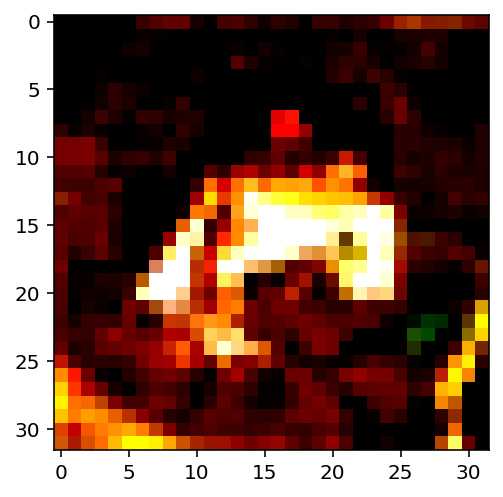

In [3]:
print(trainset[0][0].shape)
plt.imshow(trainset[0][0].permute(1, 2, 0))

In [6]:
# необходимые глобальные переменные

NUM_CLASSES = 10
INIT_SIZE = 32
FULL_PATH = Path().cwd()

In [5]:
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()
    
    progress_bar = tqdm(train_dataloader)
    idx = 0
    mean_loss = 0
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        
        mean_loss += loss
        
        optimizer.step()
        optimizer.zero_grad()
        if idx % 10 == 0:
            progress_bar.set_description("Loss = {:.4f}".format(loss.item()))
            progress_bar.set_postfix({"lr": optimizer.param_groups[0]['lr']})
        idx += 1
        
    return mean_loss / idx

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.to(device)
    model.eval()
    losses = torch.empty(0).to(device)
    predicted_classes = torch.empty(0).to(device)
    true_classes = torch.empty(0).to(device)
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            
            loss = criterion(preds, labels)
            
            preds_class = nn.LogSoftmax(dim=1)(preds).argmax(dim=1)

            losses = torch.hstack((losses, loss))        
            predicted_classes = torch.cat((predicted_classes, preds_class))            
            true_classes = torch.cat((true_classes, labels))
    
    
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    # взял из своего прошлого дз
    train_loss = []
    val_loss = []
    val_acc = []
    for epoch in range(n_epochs):
        mean_train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        
        val_losses, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device)
        mean_val_loss = val_losses.mean()

        train_loss.append(mean_train_loss.item())
        val_loss.append(mean_val_loss.item())
        val_acc.append(accuracy_score(true_classes.cpu(), predicted_classes.cpu()))
        
        if scheduler is not None:
            scheduler.step(mean_val_loss)

    return model, val_acc

### Код для кастомного LCNN

In [6]:
# mfm, group из https://github.com/AlfredXiangWu/LightCNN/blob/master/light_cnn.py

class mfm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, type=1):
        super(mfm, self).__init__()
        self.out_channels = out_channels
        if type == 1:
            self.filter = nn.Conv2d(in_channels, 2*out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.filter = nn.Linear(in_channels, 2*out_channels)

    def forward(self, x):
        x = self.filter(x)
        out = torch.split(x, self.out_channels, 1)
        return torch.max(out[0], out[1])

      
class group(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(group, self).__init__()
        self.conv_a = mfm(in_channels, in_channels, 1, 1, 0)
        self.conv   = mfm(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.conv_a(x)
        x = self.conv(x)
        return x
      

Как в статье зададим `stem` и `head`, a `body` это два (вместо трех, для упрощения) `stage`. `stem` это 1 `mfm`, `head` -- fc слой, `stage_i` -- `d_i` слоев типа `group.` Как в статье подгоним `kernel_size` и `stride\padding` правильным образом, чтобы в `head` на входе ширина\высота тензора была `INIT_SIZE / 2 ** (1 + кол-во stage)`

In [7]:
class CustomLCNN(nn.Module):
    def __init__(self, depths, widths):
        super().__init__()
        
        self.depths = depths # depth_i == #layers in stage_i (actually i+1, as stem numbering is from 1)
        self.widths = widths # widths_0 -- channels in stem, widths_i -- channels in stage_i 
        
        # define stem
        self.stem = mfm(in_channels=3, out_channels=widths[0], kernel_size=3, stride=2, padding=0)
        
        # define stage1
        stage1_list = []
        for i in range(depths[0]):
            if i == 0:
                stage1_list.append(group(in_channels=widths[0], out_channels=widths[1], 
                                        kernel_size=3, stride=2, padding=1))
            else:
                stage1_list.append(group(in_channels=widths[1], out_channels=widths[1], 
                                        kernel_size=3, stride=1, padding=1))
        stage1 = nn.Sequential(*stage1_list)
        
        # define stage2
        stage2_list = []
        for i in range(depths[1]):
            if i == 0:
                stage2_list.append(group(in_channels=widths[1], out_channels=widths[2], 
                                        kernel_size=3, stride=2, padding=1))
            else:
                stage2_list.append(group(in_channels=widths[2], out_channels=widths[2], 
                                        kernel_size=3, stride=1, padding=1))
        stage2 = nn.Sequential(*stage2_list)
        
        # define body
        self.body = nn.Sequential(stage1, stage2)
        
        # define head
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear((INIT_SIZE // (2 ** (1 + 2))) ** 2 * widths[2], NUM_CLASSES)
        )
        
    def forward(self, x):
        x = self.stem(x)
        x = self.body(x)
        x = self.head(x)
        return x

### Первое пространтство

В изначальном пространстве нет особо ограничений -- только глубина и количество каналов сверху ограничены.

Глубину и ширину (кол-во каналов) зададим по log-Uniform распределению, как в статье. Изменения касаются максимально допустимых значений (в силу ограниченности вычислительных ресурсов -- я запускаю на одной ГПУ 9xx с 2гб памяти).

Вместо 10 эпох, как в статье, используем 5. Функция потерь -- крос-энтропия, оптимизатор -- Адам (в статье СГД) с `lr=1e-3, weight_decay=1e-5`.

In [8]:
def ModelSpace_Start(max_depth=8, max_width=64, index=0, n_epochs=5):
    depths = np.exp(np.random.uniform(np.log(1), np.log(max_depth), 2)).astype(int)
    widths = np.exp(np.random.uniform(np.log(3), np.log(max_width), 3)).astype(int)
    depths = [elem.item() for elem in depths]
    widths = [elem.item() for elem in widths]
    print(f'Depths: {depths}')
    print(f'Widths: {widths}')
    
    model = CustomLCNN(depths, widths)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = None
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    _, acc = train(model, trainloader, testloader, criterion, optimizer, device, n_epochs, scheduler)
    
    # посчитаем сложность модели заранее
    flops, params = get_model_complexity_info(model, (3, 32, 32), flops_units='MMac', param_units='K',
                                             as_strings=False, print_per_layer_stat=False)
        
    # сохраним все в папку
    os.makedirs(str(FULL_PATH / 'models_start'), exist_ok=True)
    model_dict = {
        'model_state_dict': model.state_dict(),
        'depths': depths,
        'widths': widths,
        'error_rate': 1 - acc[-1],
        'flops': flops,
        'params': params,
    }
    torch.save(model_dict, str(FULL_PATH / 'models_start' / f'model_{index}'))
    
    clear_output()

In [12]:
for i in range(100):
    print('Sampling model number', i)
    ModelSpace_Start(index=i, n_epochs=5)

### Вспогательные функции для анализа

In [2]:
# загрузка сохраненных моделей
def load_models(space_name):
    saved_dicts = []
    for name in os.listdir(str(FULL_PATH / f'models_{space_name}')):
        saved_dict = torch.load(str(FULL_PATH / f'models_{space_name}' / name), map_location='cpu')
        del saved_dict['model_state_dict'] # тут нам не понадобится, мы все, что нужно преподсчитали
        saved_dicts.append(saved_dict)
                                                
    saved_dicts = sorted(saved_dicts, key=lambda x: x['error_rate'])
    
    return saved_dicts 

# анализ пространтсва через error_rate
def EDF(error_rates, e):
    return (error_rates < e).sum() / len(error_rates)
  
def get_errors_from_space(models):
    errors = [elem['error_rate'] for elem in models]
    return np.array(errors)
  
def plot_EDF(array_of_spaces, array_names, array_colors, erange=(0, 1)):
    array_of_errors = []
    for i in range(len(array_of_spaces)):
        array_of_errors.append(get_errors_from_space(array_of_spaces[i]))
    e_values = np.linspace(*erange)
    edf = np.zeros((len(array_of_errors), e_values.shape[0]))
    for i in range(e_values.shape[0]):
        for j in range(len(array_of_errors)):
          edf[j][i] = EDF(array_of_errors[j], e_values[i])
        
    plt.figure(figsize=(5,5))
    for j in range(len(array_of_errors)):
      plt.plot(e_values*100, edf[j], color=array_colors[j], label=f'{array_names[j]}_space')
    plt.xlabel('error, %')
    plt.ylabel('comulative prob')
    plt.legend()
    plt.show()  
    
def plot_error_depth(space):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    errors = get_errors_from_space(space)
    for i in range(2):
        depth = [elem['depths'][i] for elem in space]
        axes[i].scatter(depth, errors, alpha=0.5)
        axes[i].set_xlabel('depth')
        axes[i].set_ylabel('error')
        axes[i].set_title(f'depth_{i} vs error')
        
    depth1 = [elem['depths'][0] for elem in space]
    depth2 = [elem['depths'][1] for elem in space]
    depth_full = np.array(depth1) + np.array(depth2)
    
    axes[2].scatter(depth_full, errors, alpha=0.5)

    axes[2].set_xlabel('depth')
    axes[2].set_ylabel('error')
    axes[2].set_title(f'sum_depth vs error')
    
    fig.tight_layout()
    plt.show()
    
def plot_error_width(space):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    errors = get_errors_from_space(space)
    for i in range(3):
        depth = [elem['widths'][i] for elem in space]
        axes[i].scatter(depth, errors, alpha=0.5)
        axes[i].set_xlabel('widths')
        axes[i].set_ylabel('error')
        axes[i].set_title(f'widths_{i} vs error')
    fig.tight_layout()
    plt.show()
    
def plot_best_width(space):
    top_3 = space[:3]
    errors = get_errors_from_space(top_3)
    widths = [elem['widths'] for elem in top_3]
    depths = [elem['depths'] for elem in top_3]
    plot_widths = [[widths[0][0]], [widths[1][0]], [widths[2][0]]]
    for i in range(len(depths)):
        plot_widths[i] += [widths[i][1]] * int(depths[i][0]) + [widths[i][2]] * int(depths[i][1])
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axes[i].plot(plot_widths[i])
        axes[i].scatter(np.arange(len(plot_widths[i])), plot_widths[i])
        axes[i].set_title(f'top_{i} model, error = {errors[i]}')
        axes[i].set_xlabel('width_number')
        axes[i].set_ylabel('width')
        axes[i].plot([], [], ' ', label=f'depths: {depths[i]}')
        axes[i].plot([], [], ' ', label=f'widths: {widths[i]}')
        axes[i].legend()
    fig.tight_layout()
    plt.show()
    
def plot_worst_width(space):
    bad_3 = space[-3:]
    errors = get_errors_from_space(bad_3)
    widths = [elem['widths'] for elem in bad_3]
    depths = [elem['depths'] for elem in bad_3]
    plot_widths = [[widths[0][0]], [widths[1][0]], [widths[2][0]]]
    for i in range(len(depths)):
        plot_widths[i] += [widths[i][1]] * int(depths[i][0]) + [widths[i][2]] * int(depths[i][1])
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axes[i].plot(plot_widths[i])
        axes[i].scatter(np.arange(len(plot_widths[i])), plot_widths[i])
        axes[i].set_title(f'bad_{i} model, error = {errors[i]}')
        axes[i].set_xlabel('width_number')
        axes[i].set_ylabel('width')
        axes[i].plot([], [], ' ', label=f'depths: {depths[i]}')
        axes[i].plot([], [], ' ', label=f'widths: {widths[i]}')
        axes[i].legend()
    fig.tight_layout()
    plt.show()

### Анализ изначального пространтства

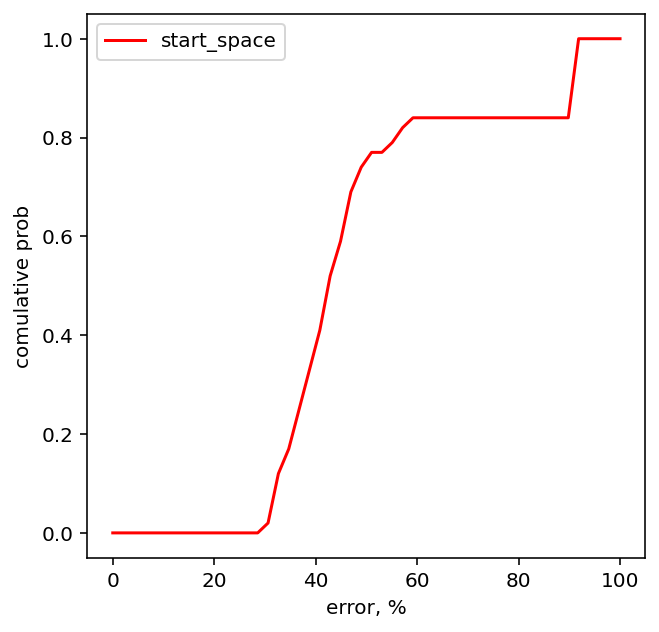

In [17]:
start_models = load_models('start')

plot_EDF([start_models], ['start'], ['red'])

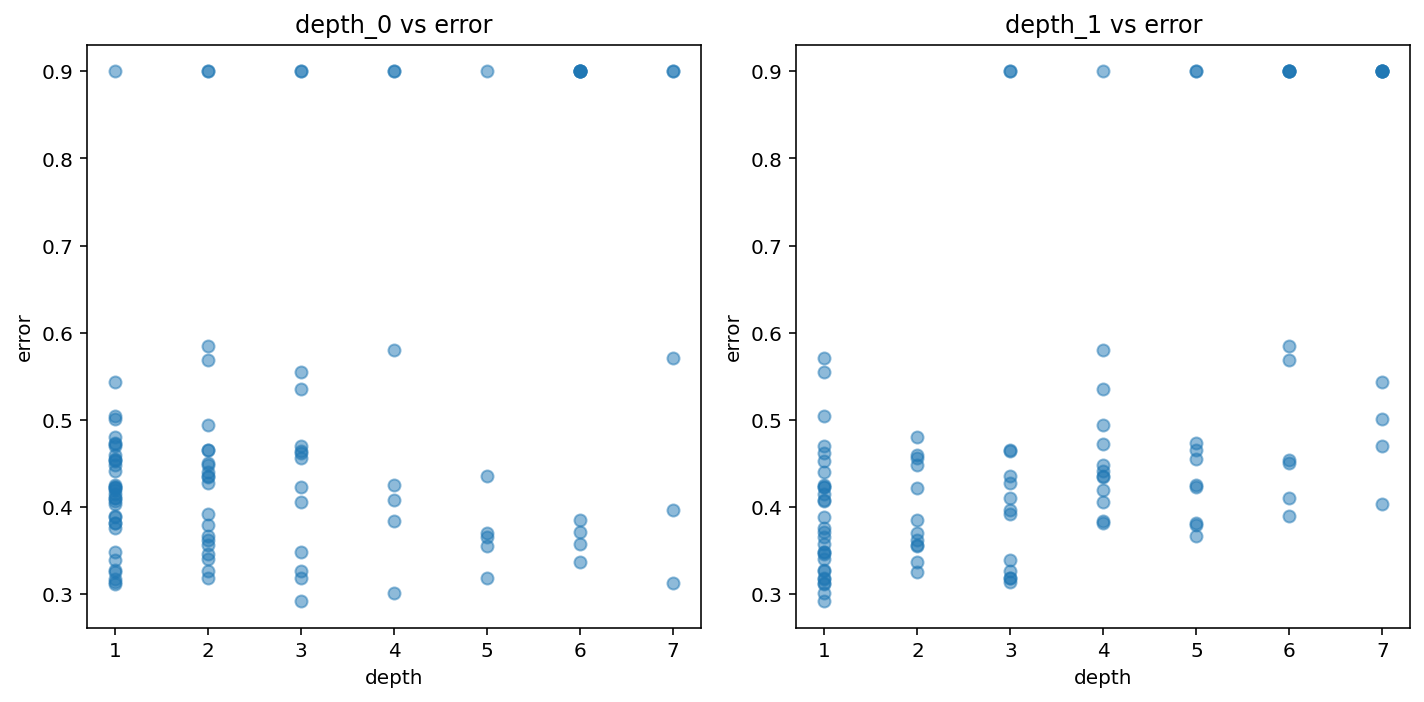

In [31]:
plot_error_depth(start_models)

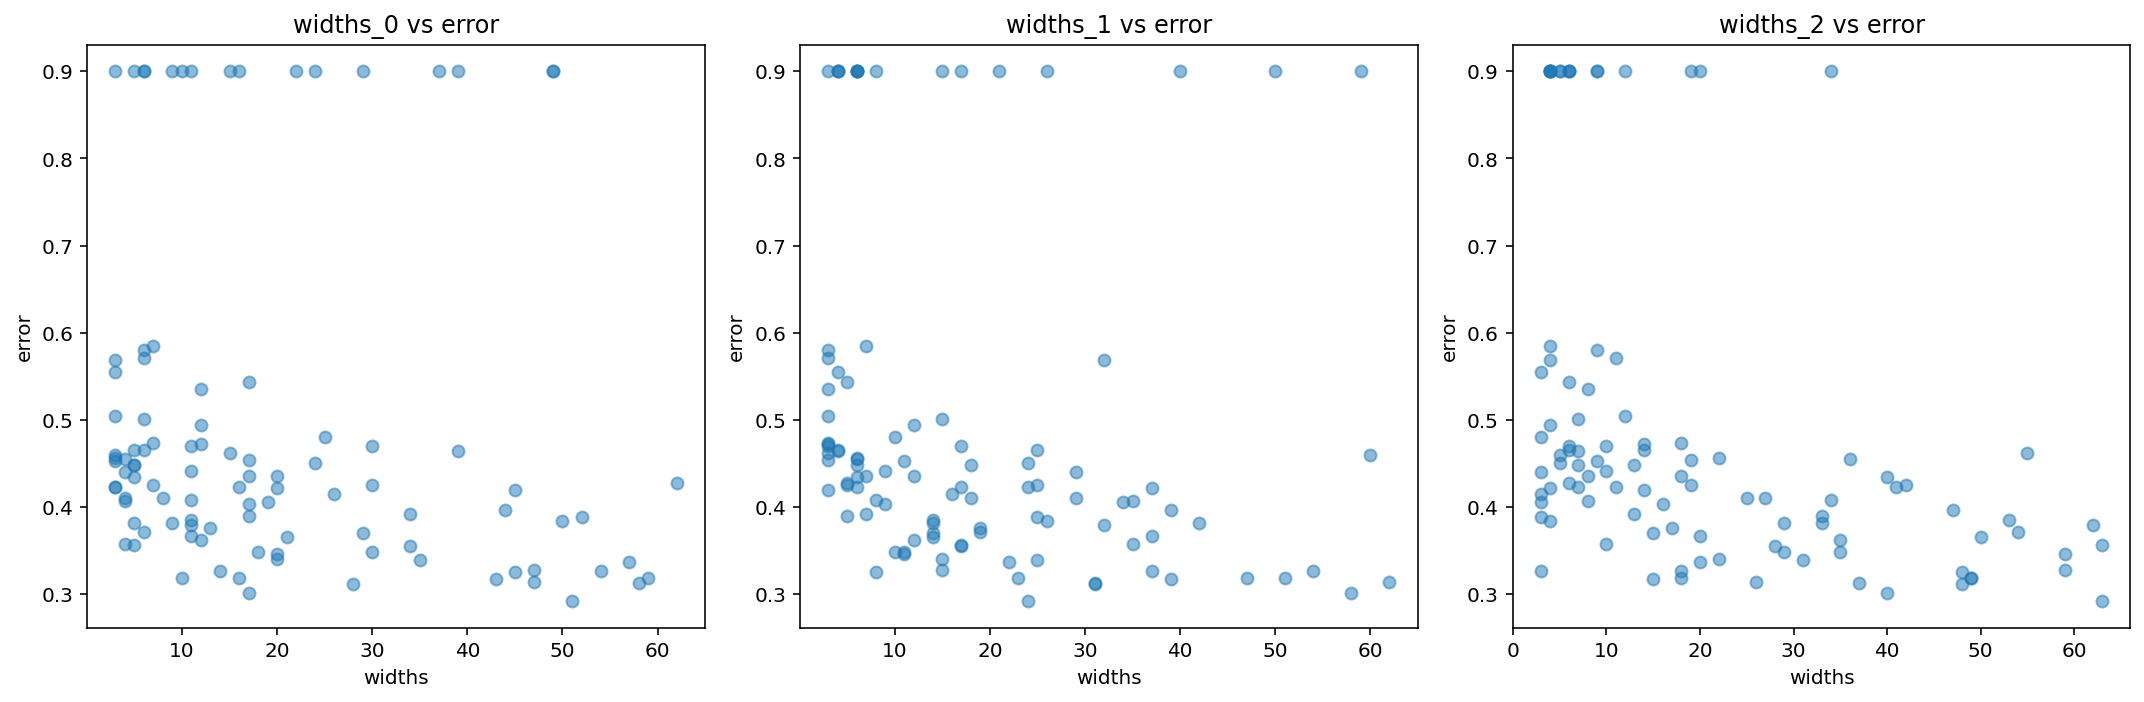

In [32]:
plot_error_width(start_models)

Построим зависимость `error_rate` от количества каналов для топ-3 лучших и худших моделей, как это делалось в статье

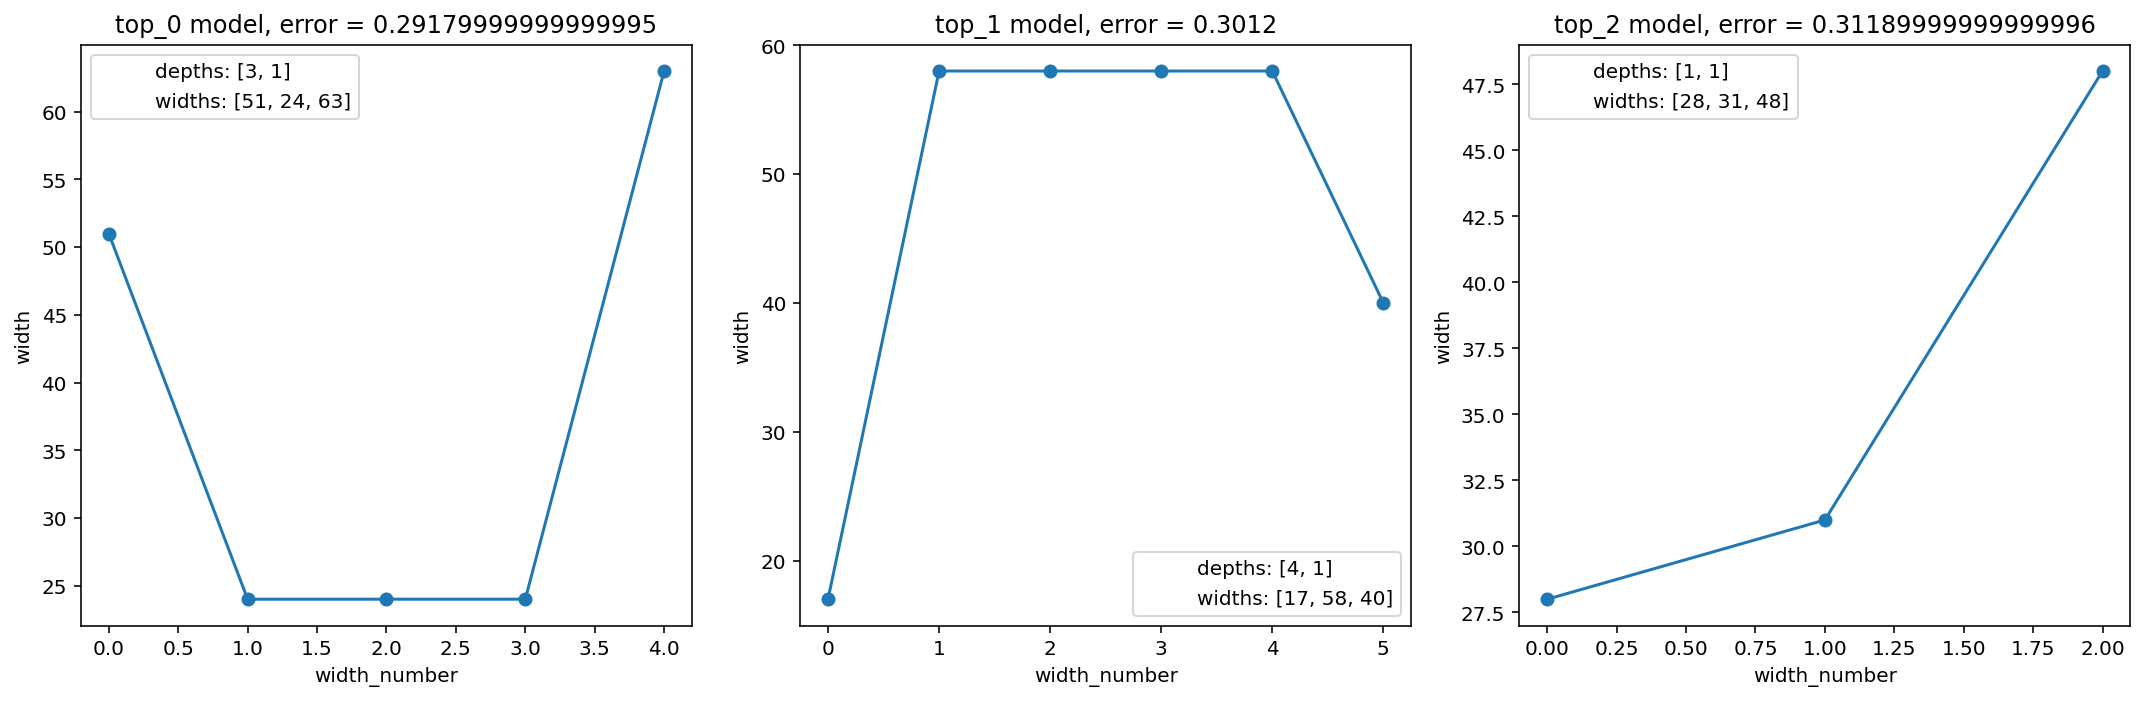

In [74]:
plot_best_width(start_models)

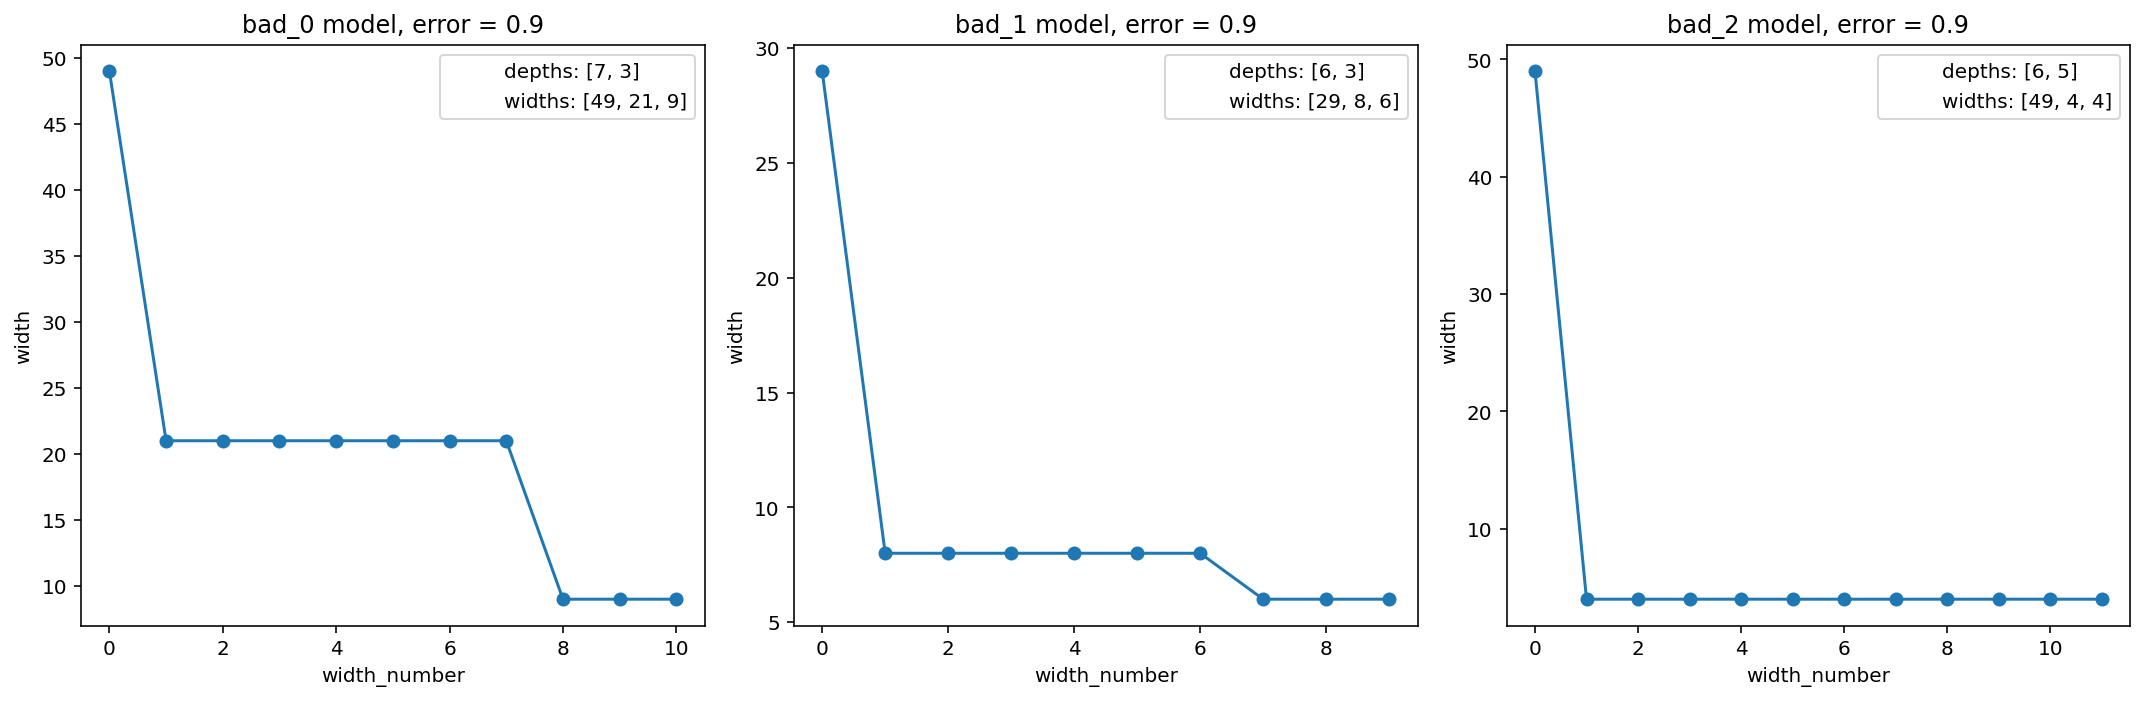

In [75]:
plot_worst_width(start_models)

Видно, что для худших моделей $w_i > w_{i+1}$, что похоже на эффект, наблюдаемый в статье. Для лучших моделей почти выполнено $w_i \le w_{i+1}$, но в отличии от статьи именно "почти": видно, что второй канал бывает разный, но всегда $w_0 < w_3$. 

Одно из изменений в статье было сужение по принципу $w_i \le w_{i+1}$. Хоть мы и не получили ровно такое условие, давайте проверим его

### Второе пространство

In [8]:
def ModelSpace_Width(max_depth=8, max_width=64, index=0, n_epochs=5):
    depths = np.exp(np.random.uniform(np.log(1), np.log(max_depth), 2)).astype(int)
    widths = np.exp(np.random.uniform(np.log(3), np.log(max_width), 3)).astype(int)
    widths = np.sort(widths) # теперь w_i <= w_{i+1}
    
    depths = [elem.item() for elem in depths]
    widths = [elem.item() for elem in widths]
    print(f'Depths: {depths}')
    print(f'Widths: {widths}')
    
    model = CustomLCNN(depths, widths)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = None
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    _, acc = train(model, trainloader, testloader, criterion, optimizer, device, n_epochs, scheduler)
    
    # посчитаем сложность модели заранее
    flops, params = get_model_complexity_info(model, (3, 32, 32), flops_units='MMac', param_units='K',
                                             as_strings=False, print_per_layer_stat=False)
        
    # сохраним все в папку
    os.makedirs(str(FULL_PATH / 'models_width'), exist_ok=True)
    model_dict = {
        'model_state_dict': model.state_dict(),
        'depths': depths,
        'widths': widths,
        'error_rate': 1 - acc[-1],
        'flops': flops,
        'params': params,
    }
    torch.save(model_dict, str(FULL_PATH / 'models_width' / f'model_{index}'))
    
    clear_output()

In [9]:
for i in range(100):
    print('Sampling model number', i)
    ModelSpace_Width(index=i, n_epochs=5)

### Анализ второго пространства

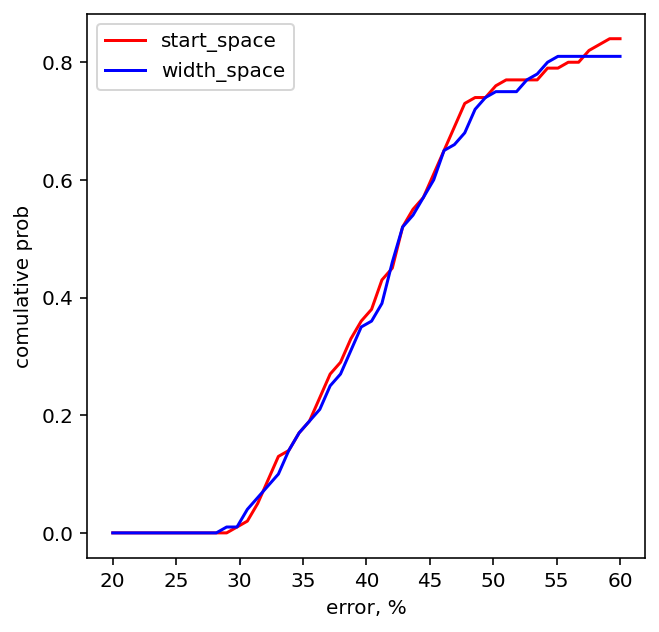

In [16]:
start_models = load_models('start')
width_models = load_models('width')

plot_EDF([start_models, width_models], ['start', 'width'], ['red', 'blue'], erange=(0.2, 0.6))

Видим, что особо лучше не стало, поэтому давайте попробуем все-таки $w_0 < w_2, \forall w_1 != w_0, w_2$

In [9]:
def ModelSpace_Width2(max_depth=8, max_width=64, index=0, n_epochs=5):
    depths = np.exp(np.random.uniform(np.log(1), np.log(max_depth), 2)).astype(int)
    widths = np.exp(np.random.uniform(np.log(3), np.log(max_width), 3)).astype(int)
    while np.unique(widths).shape[0] != 3:
        widths = np.exp(np.random.uniform(np.log(3), np.log(max_width), 3)).astype(int)
    if widths[0] > widths[2]:
        widths[0], widths[2] = widths[2], widths[0]
    
    depths = [elem.item() for elem in depths]
    widths = [elem.item() for elem in widths]
    print(f'Depths: {depths}')
    print(f'Widths: {widths}')
    
    model = CustomLCNN(depths, widths)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = None
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    _, acc = train(model, trainloader, testloader, criterion, optimizer, device, n_epochs, scheduler)
    
    # посчитаем сложность модели заранее
    flops, params = get_model_complexity_info(model, (3, 32, 32), flops_units='MMac', param_units='K',
                                             as_strings=False, print_per_layer_stat=False)
        
    # сохраним все в папку
    os.makedirs(str(FULL_PATH / 'models_width2'), exist_ok=True)
    model_dict = {
        'model_state_dict': model.state_dict(),
        'depths': depths,
        'widths': widths,
        'error_rate': 1 - acc[-1],
        'flops': flops,
        'params': params,
    }
    torch.save(model_dict, str(FULL_PATH / 'models_width2' / f'model_{index}'))
    
    clear_output()

In [10]:
for i in range(100):
    print('Sampling model number', i)
    ModelSpace_Width2(index=i, n_epochs=5)

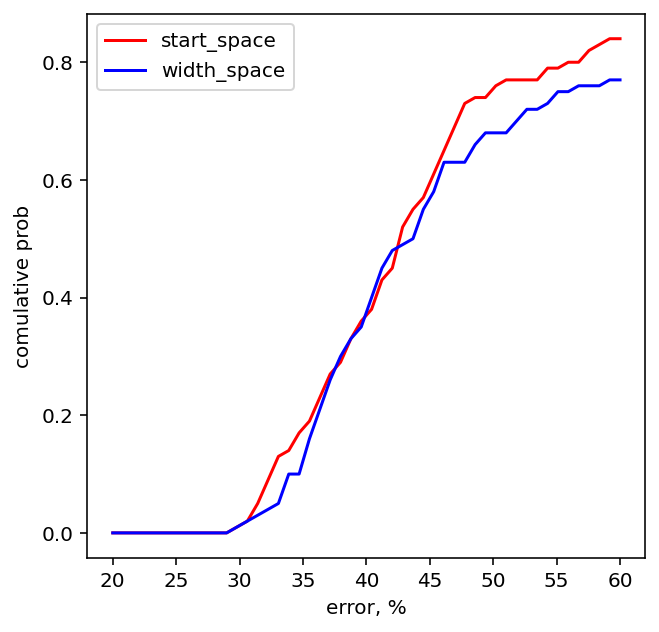

In [13]:
start_models = load_models('start')
width_models = load_models('width2')

plot_EDF([start_models, width_models], ['start', 'width'], ['red', 'blue'], erange=(0.2, 0.6))

Стало только хуже

### Третье пространтство

Из тех же графиков для `start_space` видно, что у лучших моделей последняя глубина равна 1, а у худших не 1. Попробуем зафиксироввать вторую глубину как 1.

In [10]:
def ModelSpace_Depth(max_depth=8, max_width=64, index=0, n_epochs=5):
    depths = np.exp(np.random.uniform(np.log(1), np.log(max_depth), 2)).astype(int)
    widths = np.exp(np.random.uniform(np.log(3), np.log(max_width), 3)).astype(int)
    
    depths[1] = 1
    
    depths = [elem.item() for elem in depths]
    widths = [elem.item() for elem in widths]
    print(f'Depths: {depths}')
    print(f'Widths: {widths}')
    
    model = CustomLCNN(depths, widths)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = None
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    _, acc = train(model, trainloader, testloader, criterion, optimizer, device, n_epochs, scheduler)
    
    # посчитаем сложность модели заранее
    flops, params = get_model_complexity_info(model, (3, 32, 32), flops_units='MMac', param_units='K',
                                             as_strings=False, print_per_layer_stat=False)
        
    # сохраним все в папку
    os.makedirs(str(FULL_PATH / 'models_depth'), exist_ok=True)
    model_dict = {
        'model_state_dict': model.state_dict(),
        'depths': depths,
        'widths': widths,
        'error_rate': 1 - acc[-1],
        'flops': flops,
        'params': params,
    }
    torch.save(model_dict, str(FULL_PATH / 'models_depth' / f'model_{index}'))
    
    clear_output()

In [11]:
for i in range(100):
    print('Sampling model number', i)
    ModelSpace_Depth(index=i, n_epochs=5)

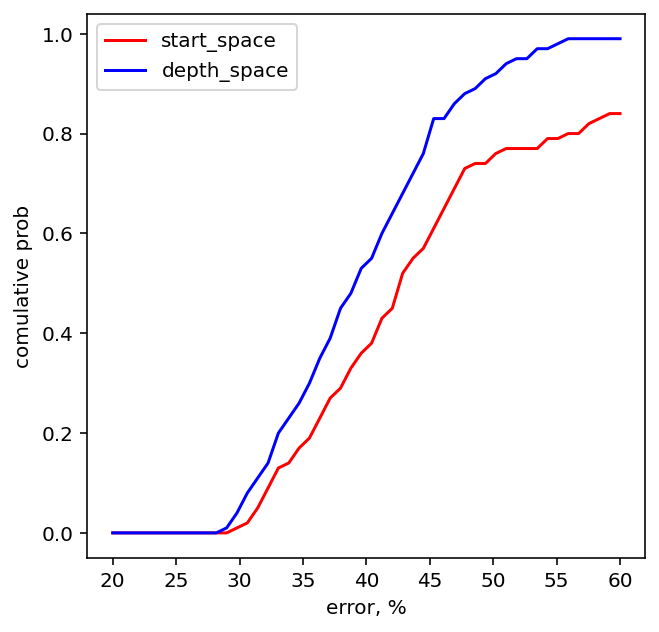

In [12]:
start_models = load_models('start')
depth_models = load_models('depth')

plot_EDF([start_models, depth_models], ['start', 'depth'], ['red', 'blue'], erange=(0.2, 0.6))

Попробуем взять оба условия: и на глубину и на ширину

In [11]:
def ModelSpace_Depth2(max_depth=8, max_width=64, index=0, n_epochs=5):
    depths = np.exp(np.random.uniform(np.log(1), np.log(max_depth), 2)).astype(int)
    widths = np.exp(np.random.uniform(np.log(3), np.log(max_width), 3)).astype(int)
    while np.unique(widths).shape[0] != 3:
        widths = np.exp(np.random.uniform(np.log(3), np.log(max_width), 3)).astype(int)
    if widths[0] > widths[2]:
        widths[0], widths[2] = widths[2], widths[0]
    
    depths[1] = 1
    
    depths = [elem.item() for elem in depths]
    widths = [elem.item() for elem in widths]
    print(f'Depths: {depths}')
    print(f'Widths: {widths}')
    
    model = CustomLCNN(depths, widths)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = None
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    _, acc = train(model, trainloader, testloader, criterion, optimizer, device, n_epochs, scheduler)
    
    # посчитаем сложность модели заранее
    flops, params = get_model_complexity_info(model, (3, 32, 32), flops_units='MMac', param_units='K',
                                             as_strings=False, print_per_layer_stat=False)
        
    # сохраним все в папку
    os.makedirs(str(FULL_PATH / 'models_depth2'), exist_ok=True)
    model_dict = {
        'model_state_dict': model.state_dict(),
        'depths': depths,
        'widths': widths,
        'error_rate': 1 - acc[-1],
        'flops': flops,
        'params': params,
    }
    torch.save(model_dict, str(FULL_PATH / 'models_depth2' / f'model_{index}'))
    
    clear_output()

In [12]:
for i in range(100):
    print('Sampling model number', i)
    ModelSpace_Depth2(index=i, n_epochs=5)

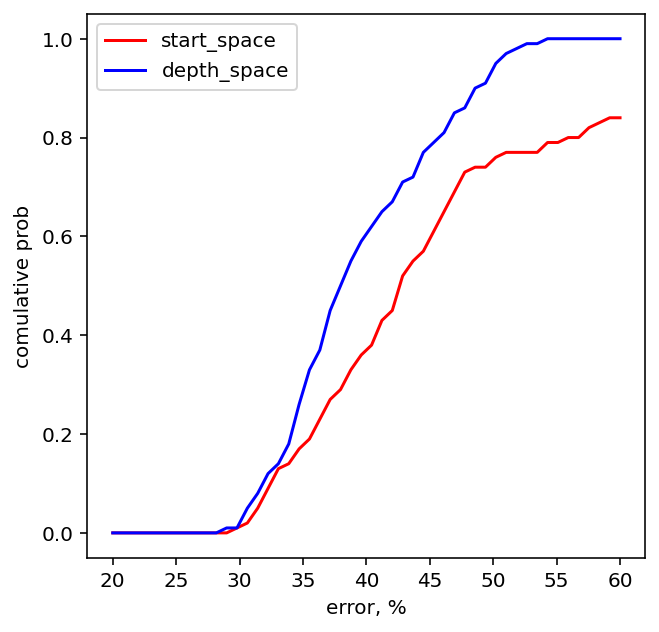

In [14]:
start_models = load_models('start')
depth_models = load_models('depth2')

plot_EDF([start_models, depth_models], ['start', 'depth'], ['red', 'blue'], erange=(0.2, 0.6))

Сравним

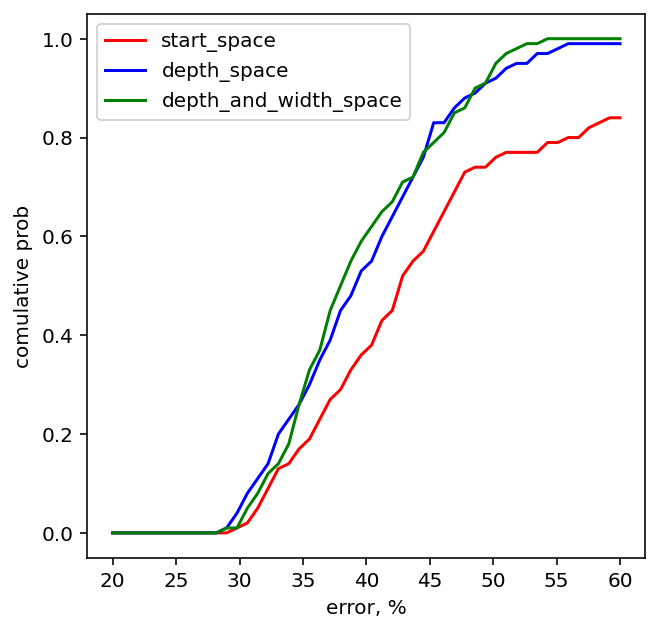

In [8]:
start_models = load_models('start')
depth_models = load_models('depth')
depth2_models = load_models('depth2')

plot_EDF([start_models, depth_models, depth2_models], ['start', 'depth', 'depth_and_width'],
         ['red', 'blue', 'green'], erange=(0.2, 0.6))

Видно, что основной прирост дает именно глубина, а условие на число каналов мало что меняет -- на более высоких `error_rate` чуть лучше, на более низких чуть хуже

#### Вывод

Следуя предложенной методологии действительно можно рассматривать статистики и делать на них выводы, приводящие к сужению пространтства. Однако точный алгоритм действий зависит от задачи и не факт, что сужения, работающие для одного типа пространства, работают для других. Так, в нашем случае метод с каналами не сработал.